# CMRL Live Ridership Information

Live data from the Chennai Metro is available on CMRL's portal at [https://commuters-data.chennaimetrorail.org/passengerflow](https://commuters-data.chennaimetrorail.org/passengerflow) with existing visualisations.

This Notebook will go through manipulating the source JSON response data from CMRL's API (Found through network traffic analysis on the website) in order to recreate the same visualisations. We will then explore how we can extrapolate more information, learn about the metro network, and some observations and scripts we can make and what they signify in the real world.

### Collecting and basic processing of bulk data

In [2]:
import requests

base_url = "https://commuters-dataapi.chennaimetrorail.org/api/PassengerFlow/"
day = "1" # '1' for previous day, '0' for current day
# Note : Depending on time of day, /0 may have incomplete data. Since we would rather deal with complete data, we use /1.

daily_ticket_count_url = base_url + "allTicketCount/" + day
hourly_passenger_data_url = base_url + "hourlybaseddata/" + day
station_flow_data_url = base_url + "stationData/" + day

In [3]:
import pandas as pd

def get_daily_ticket_count():
    response = requests.get(daily_ticket_count_url).json()
    return response

def get_hourly_passenger_data():
    response = requests.get(hourly_passenger_data_url).json()
    hourly_data = {
        'timestamps': [pd.to_datetime(ts).strftime('%H:%M') for ts in response['categories']],
        'series': {s['name']: s['data'] for s in response['series']}
    }
    return hourly_data

STATION_CODES = { # one-to-one mapping -> more compact and unambiguous
    # Blue Line
    "WIMCO NAGAR DEPOT":"SWD",
    "WIMCO NAGAR METRO":"SWN",
    "THIRUVOTRIYUR METRO":"STV",
    "THIRUVOTRIYUR THERADI METRO":"STT",
    "KALADIPET METRO":"SKP",
    "TOLLGATE METRO":"STG",
    "NEW WASHERMENPET METRO":"SNW",
    "TONDIARPET METRO":"STR",
    "THIYAGARAYA COLLEGE METRO":"STC",
    "WASHERMANPET":"SWA",
    "MANNADI":"SMA",
    "HIGH COURT":"SHC",
    "GOVERNMENT ESTATE":"SGE",
    "LIC":"SLI",
    "THOUSAND LIGHT":"STL",
    "AG-DMS":"SGM",
    "TEYNAMPET":"STE",
    "NANDANAM":"SCR",
    "SAIDAPET":"SSA",
    "LITTLE MOUNT":"SLM",
    "GUINDY":"SGU",
    "OTA - NANGANALLUR ROAD":"SOT",
    "MEENAMBAKKAM":"SME",
    "CHENNAI AIRPORT":"SAP",

    # Green Line
    "EGMORE":"SEG",
    "NEHRU PARK":"SNP",
    "KILPAUK":"SKM",
    "PACHAIAPPA S COLLEGE":"SPC",
    "SHENOY NAGAR":"SSN",
    "ANNA NAGAR EAST":"SAE",
    "ANNA NAGAR TOWER":"SAT",
    "THIRUMANGALAM":"STI",
    "KOYAMBEDU":"SKO",
    "CMBT":"SCM",
    "ARUMBAKKAM":"SAR",
    "VADAPALANI":"SVA",
    "ASHOK NAGAR":"SAN",
    "EKKATTUTHANGAL":"SSI",
    "St. THOMAS MOUNT":"SMM",

    # Interchange station
    "CENTRAL  METRO":"SCC",
    "ALANDUR":"SAL",
}

def get_station_flow_data():
    response = requests.get(station_flow_data_url).json()
    station_data = {}
    for line_data in response:
        line_number = line_data['line']
        station_data[line_number] = {
            'categories': [STATION_CODES[i] for i in line_data['categories']], # Station codes
            'series': {s['name']: s['data'] for s in line_data['series']}
        }
    return station_data

daily_tickets = get_daily_ticket_count()
hourly_passengers = get_hourly_passenger_data()
station_flows = get_station_flow_data()

print("Daily Ticket Count (first 5 items):", dict(list(daily_tickets.items())[:5]))
print("\nHourly Passenger Data (timestamps and a sample series):\nTimestamps:", hourly_passengers['timestamps'][:5], "\nTotal Series (first 5 data points):", hourly_passengers['series']['Total'][:5])
print("\nStation Flow Data (sample for line 01, categories and a sample series):\nCategories:", station_flows['01']['categories'][:5], "\nTotal Series (first 5 data points for Line 01):", station_flows['01']['series']['Total'][:5])

Daily Ticket Count (first 5 items): {'totalTickets': 373973, 'noOfSVC': 1546, 'noOfNCMCcard': 203286, 'noOfMobileQR': 4456, 'noOfStaticQR': 8041}

Hourly Passenger Data (timestamps and a sample series):
Timestamps: ['00:00', '02:00', '04:00', '05:00', '06:00'] 
Total Series (first 5 data points): [38, 1, 1024, 3675, 6076]

Station Flow Data (sample for line 01, categories and a sample series):
Categories: ['SWD', 'SWN', 'STV', 'STT', 'SKP'] 
Total Series (first 5 data points for Line 01): [5379, 5328, 5361, 6810, 5640]


### Recreating the CMRL Dashboards

Now that we have access to the same data as the official dashboard, let's try to make an authentic recreation of the visualisations they provide

[Here is the official Passenger Flow website](https://commuters-data.chennaimetrorail.org/passengerflow)

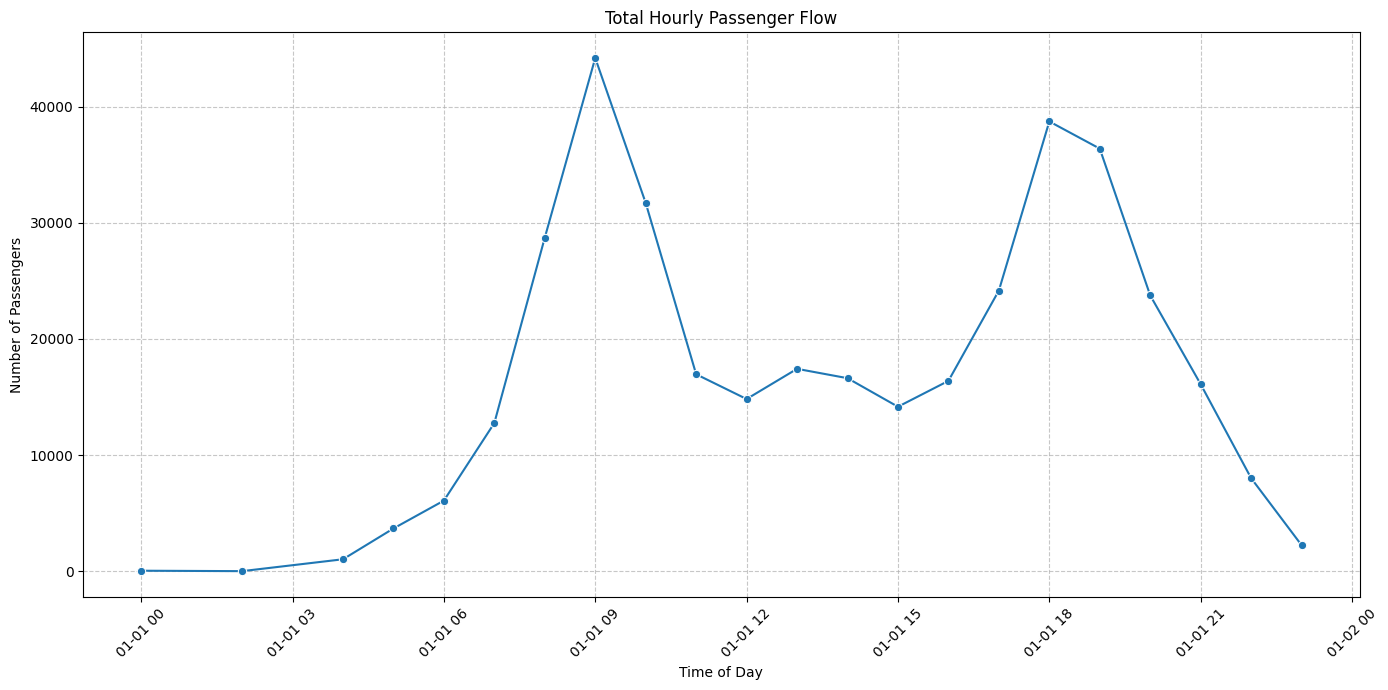

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

hourly_df = pd.DataFrame({
    'Time': hourly_passengers['timestamps'],
    'Total Passengers': hourly_passengers['series']['Total']
})

# Convert 'Time' to datetime objects for proper sorting and plotting on the x-axis
hourly_df['Time'] = pd.to_datetime(hourly_df['Time'], format='%H:%M')

# Sort by time to ensure the plot is ordered correctly
hourly_df = hourly_df.sort_values(by='Time')

plt.figure(figsize=(14, 7))
sns.lineplot(x='Time', y='Total Passengers', data=hourly_df, marker='o')

plt.title('Total Hourly Passenger Flow')
plt.xlabel('Time of Day')
plt.ylabel('Number of Passengers')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### Hourly Passenger Flow with Payment Method Share

This plot visualizes the total hourly passenger flow as a bar graph, with each individual payment method shown as a cumulative line graph on top. This allows us to see the share of each fare method contributing to the total passenger count at any given hour.

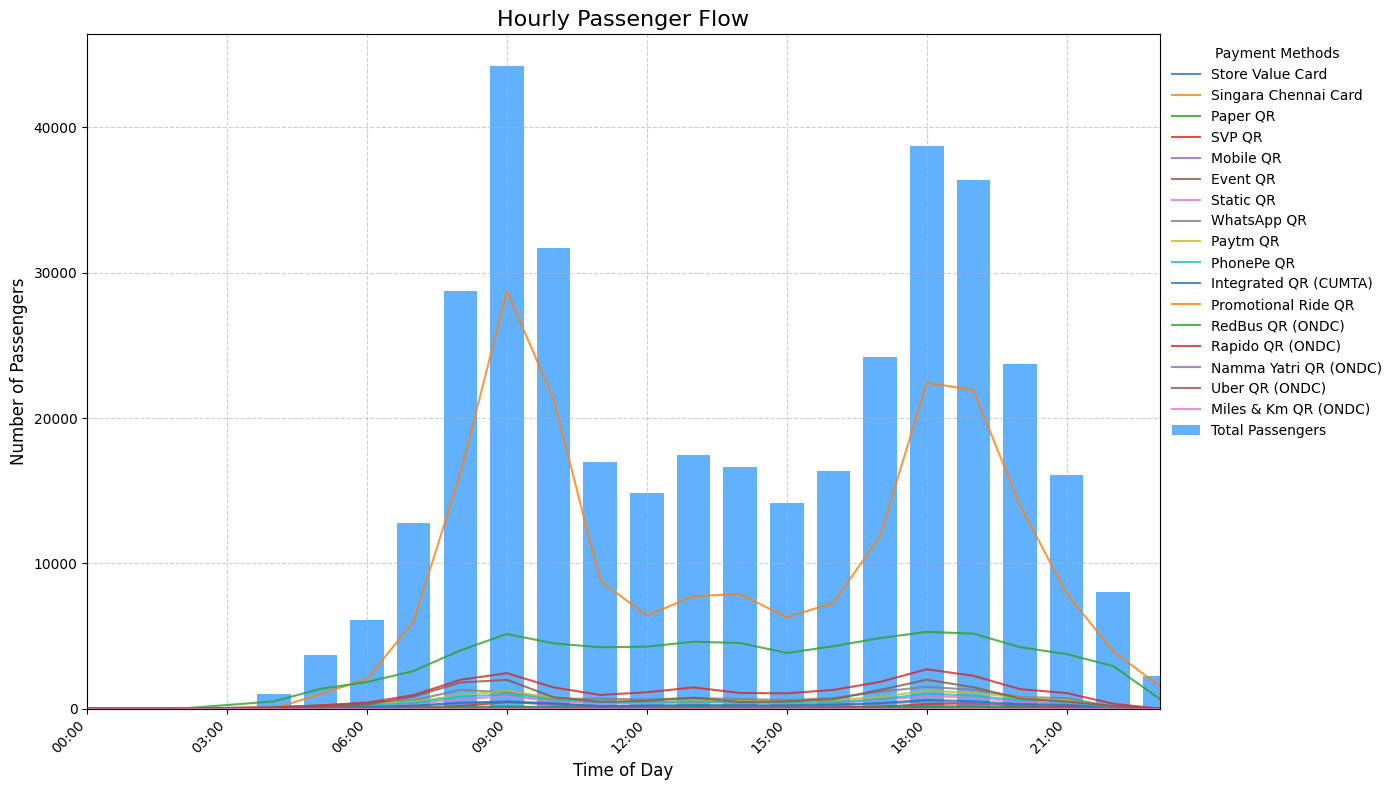

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.dates import DateFormatter

# Use hour for x-axis
df_plot = pd.DataFrame({
    'Time_str': hourly_passengers['timestamps'],
    'Total': hourly_passengers['series']['Total'] # Base layer is total passengers
})
df_plot['Time_dt'] = pd.to_datetime(df_plot['Time_str'], format='%H:%M')

# Sort data by time
df_plot = df_plot.sort_values('Time_dt').reset_index(drop=True)

# Add individual payment methods data
payment_methods = [name for name in hourly_passengers['series'].keys() if name != 'Total']
for method in payment_methods:
    df_plot[method] = hourly_passengers['series'][method]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot Total as a bar graph
ax.bar(df_plot['Time_dt'], df_plot['Total'], width=0.03, align='center', label='Total Passengers', color='dodgerblue', alpha=0.7)

# Plot each individual payment method as a separate line graph
for method in payment_methods:
    ax.plot(df_plot['Time_dt'], df_plot[method], label=method, alpha=0.8)

plot_title = 'Hourly Passenger Flow'
ax.set_title(plot_title, fontsize=16)
ax.set_xlabel('Time of Day', fontsize=12)
ax.set_ylabel('Number of Passengers', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45, ha='right')

min_time = df_plot['Time_dt'].min()
max_time = df_plot['Time_dt'].max()
ax.set_xlim(min_time, max_time)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Payment Methods', frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

### Interactive Hourly Passenger Flow with Payment Method Share

The actual dashboard on the website isn't static, when hovering over a certain hour, it lets us view the actual numbers for each payment method. We can use plotly to make an interactive version of the existing dashboard.

In [6]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# readable date format
first_timestamp_raw = hourly_passengers['timestamps'][0]
date_obj = pd.to_datetime(first_timestamp_raw)
readable_date = date_obj.strftime('%B %d, %Y')

# Base bar graph of totals
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_plot['Time_dt'],
    y=df_plot['Total'],
    name='Total Passengers',
    marker_color='lightgray',
    opacity=0.7,
    hovertemplate='<b>Total Passengers</b>: %{y}<extra></extra>'
))

# Add individual payment method line traces
payment_methods = [name for name in hourly_passengers['series'].keys() if name != 'Total']
for method in payment_methods:
    fig.add_trace(go.Scatter(
        x=df_plot['Time_dt'],
        y=df_plot[method],
        mode='lines',
        name=method,
        hovertemplate='<b>'+method+'</b>: %{y}<extra></extra>'
    ))

# Title with date
base_plot_title = f'Interactive Hourly Passenger Flow with Payment Method Share ({readable_date})'

fig.update_layout(
    title_text=base_plot_title,
    xaxis_title='Time of Day',
    yaxis_title='Number of Passengers',
    xaxis_tickformat='%H:%M',
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.15,
        xanchor="center",
        x=0.5
    ),
    height=600,
    margin=dict(t=100, b=150)
)

fig.show()

### Station-wise Passenger Flow

Recreating the other two graphs depicting stations-wise passenger flow on the Blue and Green metro lines

### Line 1 - Blue

In [7]:
line_01_data = station_flows['01']
stations = line_01_data['categories']
df_line_01 = pd.DataFrame({'Station': stations})
df_line_01['Total Passengers'] = line_01_data['series']['Total']

for method_name, data in line_01_data['series'].items():
    if method_name != 'Total':
        df_line_01[method_name] = data

print("DataFrame for Line 01 (first 5 rows):\n", df_line_01.head())

DataFrame for Line 01 (first 5 rows):
   Station  Total Passengers  Store Value Card  Singara Chennai Card  Paper QR  \
0     SWD              5379                13                  3177      1106   
1     SWN              5328                14                  3153       847   
2     STV              5361                10                  3279       991   
3     STT              6810                17                  3987      1451   
4     SKP              5640                 9                  3697       947   

   SVP QR  Mobile QR  Event QR  Static QR  WhatsApp QR  Paytm QR  PhonePe QR  \
0      33         50         0         90          146       103         123   
1      41         51         0         99          208       144         161   
2      21         56         0         88          137       118         125   
3      47         68         0         85          182       116         165   
4      19         53         0         63          139        82         1

In [8]:
import plotly.graph_objects as go

fig_line_01 = go.Figure()

# bar graph for totals
fig_line_01.add_trace(go.Bar(
    x=df_line_01['Station'],
    y=df_line_01['Total Passengers'],
    name='Total Passengers',
    marker_color='lightgray',
    opacity=0.7,
    hovertemplate='<b>Total Passengers</b>: %{y}<extra></extra>'
))

# line graph for individual
payment_method_columns = [col for col in df_line_01.columns if col not in ['Station', 'Total Passengers']]
for method in payment_method_columns:
    fig_line_01.add_trace(go.Scatter(
        x=df_line_01['Station'],
        y=df_line_01[method],
        mode='lines',
        name=method,
        hovertemplate='<b>' + method + '</b>: %{y}<extra></extra>'
    ))

# layout
fig_line_01.update_layout(
    title_text='Interactive Station-wise Passenger Flow (Line 01 - Blue)',
    xaxis_title='Station',
    yaxis_title='Number of Passengers',
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    height=600,
    margin=dict(t=100, b=150)
)

fig_line_01.show()

### Line 2 - Green

In [9]:
import pandas as pd

line_02_data = station_flows['02']
stations_line_02 = line_02_data['categories']
df_line_02 = pd.DataFrame({'Station': stations_line_02})

# total
df_line_02['Total Passengers'] = line_02_data['series']['Total']

# individual
for method_name, data in line_02_data['series'].items():
    if method_name != 'Total':  # Skip 'Total' as it's already added
        df_line_02[method_name] = data

print("DataFrame for Line 02 (first 5 rows):\n", df_line_02.head())

DataFrame for Line 02 (first 5 rows):
   Station  Total Passengers  Store Value Card  Singara Chennai Card  Paper QR  \
0     SCC             11399                70                  4141      3080   
1     SEG              6755                30                  2413      2429   
2     SNP              2908                10                  1621       590   
3     SKM              2816                10                  1456       559   
4     SPC              3297                12                  1825       638   

   SVP QR  Mobile QR  Event QR  Static QR  WhatsApp QR  Paytm QR  PhonePe QR  \
0     193        468         0        266         1020       300         267   
1      34        122         0        182          271       276         262   
2      25         41         0         66           88        93          62   
3      16         23         0         51          128        94          97   
4      29         27         0         44          106        90          

In [10]:
import plotly.graph_objects as go

fig_line_02 = go.Figure()

# bar
fig_line_02.add_trace(go.Bar(
    x=df_line_02['Station'],
    y=df_line_02['Total Passengers'],
    name='Total Passengers',
    marker_color='lightgray',
    opacity=0.7,
    hovertemplate='<b>Total Passengers</b>: %{y}<extra></extra>'
))

payment_method_columns_line_02 = [col for col in df_line_02.columns if col not in ['Station', 'Total Passengers']]

# line
for method in payment_method_columns_line_02:
    fig_line_02.add_trace(go.Scatter(
        x=df_line_02['Station'],
        y=df_line_02[method],
        mode='lines',
        name=method,
        hovertemplate='<b>' + method + '</b>: %{y}<extra></extra>'
    ))

# layout
fig_line_02.update_layout(
    title_text='Interactive Station-wise Passenger Flow (Line 02 - Green)',
    xaxis_title='Station',
    yaxis_title='Number of Passengers',
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    height=600,
    margin=dict(t=100, b=150)
)

fig_line_02.show()

# Ridership on a heatmap

In [23]:
import folium
from folium.plugins import HeatMap

chennai_metro_station_coords = {
    'SGM': (13.0446755, 80.2479706),
    'SAL': (13.004202, 80.201471),
    'SAE': (13.0846, 80.2194),
    'SAT': (13.085041, 80.208728),
    'SAR': (13.0622222222222, 80.2116666666667),
    'SAN': (13.035483, 80.211329),
    'SCM': (13.0685, 80.2041),
    'SCC': (13.081464, 80.272752),
    'SAP': (12.980806, 80.164197),
    'SEG': (13.079055, 80.261105),
    'SSI': (13.017128, 80.205302),
    'SGE': (13.0695762, 80.2722682),
    'SGU': (13.009262, 80.213189),
    'SHC': (13.0873489, 80.2850209),
    'SKP': (13.1509, 80.2994),
    'SKM': (13.077536, 80.242866),
    'SKO': (13.0736, 80.1948),
    'SLI': (13.0645067, 80.2658909),
    'SLM': (13.0147843, 80.2229016),
    'SWD': (13.18341, 80.30854),
    'SWN': (13.17913, 80.30719),
    'SMA': (13.0949266, 80.2854243),
    'SME': (12.987664, 80.176459),
    'SCR': (13.0315608, 80.240694),
    'SOT': (12.999843, 80.193975),
    'SNP': (13.0787905, 80.2500871),
    'SNW': (13.1343, 80.2929),
    'SPC': (13.0755, 80.2329),
    'SSA': (13.0214141, 80.2254362),
    'SSN': (13.078799, 80.225093),
    'STC': (13.1158, 80.2847),
    'SMM': (12.9947222222222, 80.1988888888889),
    'STE': (13.0371999, 80.2457002),
    'STI': (13.085479, 80.200981),
    'STL': (13.0581433, 80.2571455),
    'STT': (13.1598132, 80.3022763),
    'STV': (13.1718, 80.3052),
    'STG': (13.1432, 80.2963),
    'STR': (13.1244, 80.2888),
    'SVA': (13.0505, 80.21208),
    'SWA': (13.1077, 80.2806),
}



In [24]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Combine station flow data from both lines
combined_station_flow = pd.concat([df_line_01[['Station', 'Total Passengers']], df_line_02[['Station', 'Total Passengers']]], ignore_index=True)

# Remove duplicate stations (e.g., Alandur, Central which appear in both lines)
# For stations appearing in both lines, we sum their ridership
combined_station_flow = combined_station_flow.groupby('Station')['Total Passengers'].sum().reset_index()

omitlist = []

# Prepare data for heatmap and calculate max_val for normalization
heat_data = []
filtered_ridership_values = []
for index, row in combined_station_flow.iterrows():
    station_code = row['Station']
    ridership = row['Total Passengers']
    if station_code in chennai_metro_station_coords and station_code not in omitlist:
        lat, lon = chennai_metro_station_coords[station_code]
        heat_data.append([lat, lon, ridership])
        filtered_ridership_values.append(ridership)
    else:
        print(f"Warning: Coordinates not found or omitted for station: {station_code}")

# Calculate max_val for heatmap based on a percentile of the filtered ridership to normalize intensity
if filtered_ridership_values:
    max_ridership_for_heatmap = pd.Series(filtered_ridership_values).quantile(0.90) # Use 90th percentile
else:
    max_ridership_for_heatmap = 1 # Fallback if no data

# Set the center of the map to a central point in Chennai
m_chennai = folium.Map(location=[13.0827, 80.2707], zoom_start=11)

# Create the HeatMap layer
HeatMap(
    data=heat_data,
    radius=20, # Increased radius for larger heat blobs
    blur=15,   # Increased blur for smoother appearance
    max_zoom=1, # Ensures the heatmap intensity doesn't disappear on zoom
    max_val=max_ridership_for_heatmap # Normalized intensity
).add_to(m_chennai)

# Add CircleMarkers for each station for better identification but less conspicuous
for station_code, coords in chennai_metro_station_coords.items():
    # Only add markers for stations included in the heatmap or all, depending on preference
    # For this request, adding for all to see all stations, but making them small
    if station_code not in omitlist: # Only add markers for stations included in heatmap
        ridership_value = combined_station_flow[combined_station_flow['Station'] == station_code]['Total Passengers'].iloc[0] if station_code in combined_station_flow['Station'].values else 'N/A'
        folium.CircleMarker(
            location=coords,
            radius=3, # Smaller radius for dot-like appearance
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=f"{station_code}: {ridership_value} passengers"
        ).add_to(m_chennai)

# Display the map
m_chennai

/tmp/ipython-input-3955289913.py:37: UserWarning:

The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.

